In [1]:
import Su22
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit import pulse              
from qiskit.circuit import Parameter 
from IPython.display import display
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel
token = 'b6464d13b284902ed1d1a48d2aed6bd0474c7be45011741b0fb879614419659cb722e74a046af3d5caae0398aec9bdac8843068ecbee91aff466cf3e30f3bef5'
try:
    IBMQ.load_account()
except:
    qk.IBMQ.save_account(token=token)
    qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
backend = provider.get_backend("ibmq_armonk")


ibmqfactory.load_account:WARNING:2022-06-19 23:25:29,464: Credentials are already in use. The existing account in the session will be replaced.


In [39]:
import pickle

def loadData(inp):
    # for reading also binary mode is important
    dbfile = open(inp, 'rb')     
    db = pickle.load(dbfile)
    counter = 0
    temp = [] 
    for key in db:
        temp.append(key)
    print(counter)
    dbfile.close()
    return temp

data=loadData('FGRAFS_controls_N128.p')
temp = []
for i in data:
    for j in range(int(4)):
        temp.append(i)
print(len(temp), " " , len(data))

0
512   128


[-0.16667963 -0.16667963 -0.16667963 -0.16667963 -0.36391907 -0.36391907
 -0.36391907 -0.36391907 -0.65355124 -0.65355124 -0.65355124 -0.65355124
 -1.04534695 -1.04534695 -1.04534695 -1.04534695 -1.54096819 -1.54096819
 -1.54096819 -1.54096819 -2.13161027 -2.13161027 -2.13161027 -2.13161027
 -2.79632331 -2.79632331 -2.79632331 -2.79632331 -3.50132882 -3.50132882
 -3.50132882 -3.50132882 -4.20057732 -4.20057732 -4.20057732 -4.20057732
 -4.8376848  -4.8376848  -4.8376848  -4.8376848  -5.34924722 -5.34924722
 -5.34924722 -5.34924722 -5.66937735 -5.66937735 -5.66937735 -5.66937735
 -5.73515271 -5.73515271 -5.73515271 -5.73515271 -5.49252667 -5.49252667
 -5.49252667 -5.49252667 -4.9021544  -4.9021544  -4.9021544  -4.9021544
 -3.94453618 -3.94453618 -3.94453618 -3.94453618 -2.62389337 -2.62389337
 -2.62389337 -2.62389337 -0.97027098 -0.97027098 -0.97027098 -0.97027098
  0.9604986   0.9604986   0.9604986   0.9604986   3.08914428  3.08914428
  3.08914428  3.08914428  5.31756577  5.31756577  5.

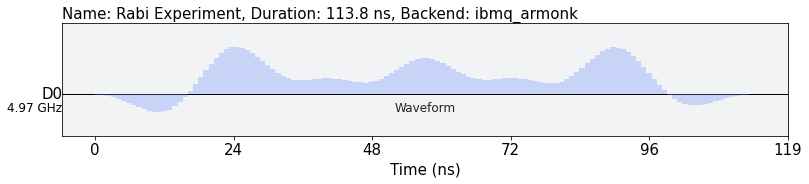

In [40]:
signal = Su22.Custom_Fgp('low_freq',temp,backend)
temp = signal.Customize_pulse(1)
with pulse.build(backend=backend) as pulse_2:
    #pulse.play(pulse.Gaussian(duration=1000,amp=1,sigma=1000, name='Rabi Pulse'), pulse.drive_channel(0))
    pulse.call(temp,pulse.drive_channel(0))
print(signal.input)
print(signal.norm)
signal.draw()

In [41]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

drive_amps_2,rabi_values_2 = signal.rabi_test_Sim(50)

[-5.03142777e-16 -4.14869822e-17  1.99999999e+00  2.78077409e-10]


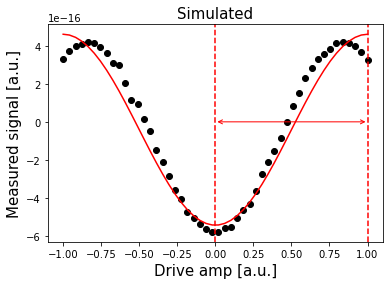

In [42]:
fit_params_2, y_fit_2 = fit_function(drive_amps_2,
                                 rabi_values_2, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [-8, 1, 2, 0])

plt.scatter(drive_amps_2, rabi_values_2, color='black')
plt.plot(drive_amps_2, y_fit_2, color='red')
print(fit_params_2)
drive_period_2 = fit_params_2[2] # get period of rabi oscillation

plt.axvline(0, color='red', linestyle='--')
plt.axvline(drive_period_2/2, color='red', linestyle='--')
plt.annotate("", xy=(0, 0), xytext=(drive_period_2/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period_2/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.title("Simulated", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [44]:
pi_amp_2 = abs(drive_period_2 / 2)
print(f"Pi Amplitude = {pi_amp_2}")

Pi Amplitude = 0.9999999950315683


In [45]:
drive_amps,rabi_values = signal.Cali(50)

Job Status: job has successfully run


[-2.36260272e-01 -4.17034730e-02  1.64399458e+00  1.01241374e-03]


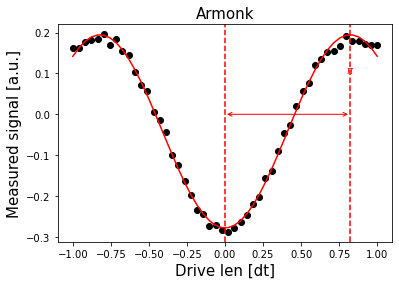

In [47]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [-8, 1, 8, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')
print(fit_params)
drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(0, color='red', linestyle='--')
plt.axvline(drive_period/2, color='red', linestyle='--')
plt.annotate("", xy=(0, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive len [dt]", fontsize=15)
plt.title("Armonk", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [48]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.8219972875407573
